In [1]:
# import nltk
# nltk.download()

In [2]:
%pylab inline
import numpy as np
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import  CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import SparsePCA

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import classification_report,confusion_matrix

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Data

### Load Data

In [3]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)

print('keys:', twenty_train.keys())
print('train data size  :', len(twenty_train.data))
print('train target size:', len(twenty_train.target))
print('test data size  :', len(twenty_test.data))
print('test target size:', twenty_test.target.shape)

keys: dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])
train data size  : 11314
train target size: 11314
test data size  : 7532
test target size: (7532,)


### Count Vectorization and Frequncy Normalization

In [4]:
# Convert a list of documents to a matrix of token counts
# (각각의 데이터, 각 단어마다 글자가 몇번 나왔는지 count한 vector)
count_vectorizer = CountVectorizer()
words_train = count_vectorizer.fit_transform(twenty_train.data)
print('CountVectorizer shape:', words_train.shape)

# TF :: Term Frequencies
# 문서가 길면.. word count도 많아지기 때문에 normalization이 필요함 
# 방법은 문서마다의 단어 갯수에서 전체 단어의 갯수를 나눠줌
# count_word(document)/total_words
# 
# TF-IDF :: Term Frequencies times Inverse Document-Frequency
# "the", "is", "an" 같은 빈번하게 나오는 단어들에 대해서도 가중치를 낮춰준다.

tfidf = TfidfTransformer()
words_train = tfidf.fit_transform(words_train)
print('TfidfTransformer shape:', words_train.shape)

CountVectorizer shape: (11314, 130107)
TfidfTransformer shape: (11314, 130107)


## Stemming

In [5]:
stemmer = SnowballStemmer('english', ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stem_vectorizer = StemmedCountVectorizer(stop_words='english')
words_train = stem_vectorizer.fit_transform(twenty_train.data)
print('Stemmed Count Vectorizer shape:', words_train.shape)


tfidf = TfidfTransformer()
words_train = tfidf.fit_transform(words_train)
print('Stemmed TfidfTransformer shape:', words_train.shape)

Stemmed Count Vectorizer shape: (11314, 110995)
Stemmed TfidfTransformer shape: (11314, 110995)


# Naive Bayes Model

In [6]:
nb_clf = Pipeline([('vector', CountVectorizer()), 
                   ('tfidf', TfidfTransformer()), 
                   ('clf', MultinomialNB())])
text_clf = nb_clf.fit(twenty_train.data, twenty_train.target)

             precision    recall  f1-score   support

          0       0.80      0.52      0.63       319
          1       0.81      0.65      0.72       389
          2       0.82      0.65      0.73       394
          3       0.67      0.78      0.72       392
          4       0.86      0.77      0.81       385
          5       0.89      0.75      0.82       395
          6       0.93      0.69      0.80       390
          7       0.85      0.92      0.88       396
          8       0.94      0.93      0.93       398
          9       0.92      0.90      0.91       397
         10       0.89      0.97      0.93       399
         11       0.59      0.97      0.74       396
         12       0.84      0.60      0.70       393
         13       0.92      0.74      0.82       396
         14       0.84      0.89      0.87       394
         15       0.44      0.98      0.61       398
         16       0.64      0.94      0.76       364
         17       0.93      0.91      0.92   

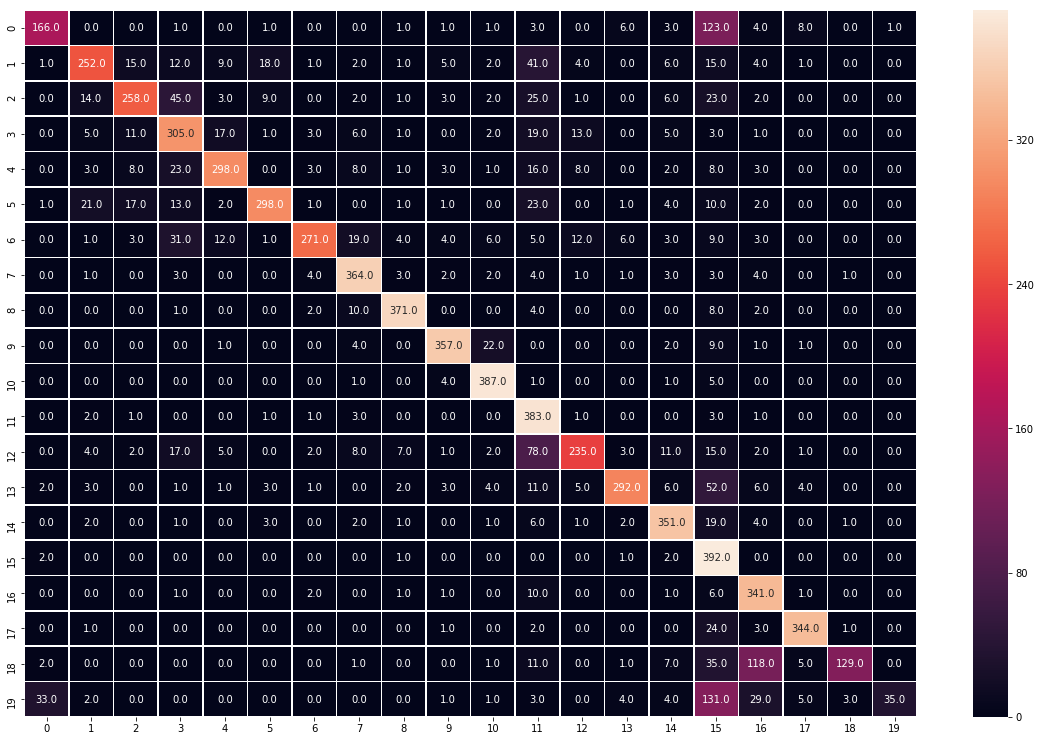

In [7]:
y_pred = text_clf.predict(twenty_test.data)

print(classification_report(twenty_test.target, y_pred))
print('Naive Bayes Accuracy:', np.mean(y_pred == twenty_test.target))
ax = plt.figure(figsize=(20, 13))
sns.heatmap(confusion_matrix(twenty_test.target, y_pred), linewidths=0.5, fmt='.1f', annot=True)

# Support Vector Machines (Linear SVM)

In [8]:
svm_clf = Pipeline([('vector', CountVectorizer()), 
                    ('tfidf', TfidfTransformer()), 
                    ('clf', SGDClassifier(loss='hinge', penalty='l2', n_iter=5))])
text_clf = svm_clf.fit(twenty_train.data, twenty_train.target)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


             precision    recall  f1-score   support

          0       0.84      0.76      0.80       319
          1       0.78      0.78      0.78       389
          2       0.74      0.73      0.74       394
          3       0.71      0.74      0.72       392
          4       0.84      0.84      0.84       385
          5       0.87      0.77      0.82       395
          6       0.83      0.91      0.87       390
          7       0.93      0.91      0.92       396
          8       0.95      0.96      0.96       398
          9       0.92      0.95      0.93       397
         10       0.95      0.98      0.96       399
         11       0.90      0.95      0.93       396
         12       0.85      0.77      0.81       393
         13       0.89      0.89      0.89       396
         14       0.89      0.96      0.92       394
         15       0.81      0.94      0.87       398
         16       0.76      0.92      0.83       364
         17       0.95      0.94      0.94   

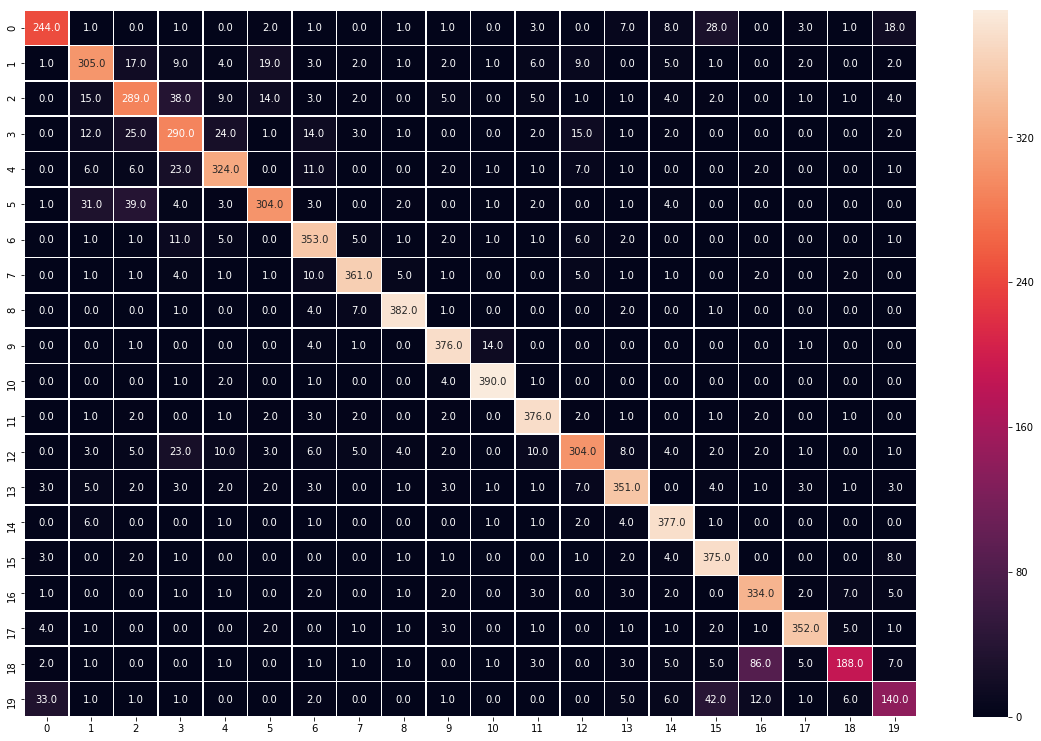

In [9]:
y_pred = text_clf.predict(twenty_test.data)

print(classification_report(twenty_test.target, y_pred))
ax = plt.figure(figsize=(20, 13))
sns.heatmap(confusion_matrix(twenty_test.target, y_pred), linewidths=0.5, fmt='.1f', annot=True)
print('SVM Accuracy:', np.mean(y_pred == twenty_test.target))

# Stemming Naive Bayes

In [10]:
stem_count_vectorizer = StemmedCountVectorizer(stop_words='english')

nb_clf = Pipeline([('vector', stem_count_vectorizer), 
                   ('tfidf', TfidfTransformer()), 
                   ('clf', MultinomialNB(fit_prior=False))])

text_clf = nb_clf.fit(twenty_train.data, twenty_train.target)

             precision    recall  f1-score   support

          0       0.80      0.70      0.75       319
          1       0.78      0.72      0.75       389
          2       0.82      0.69      0.75       394
          3       0.69      0.79      0.74       392
          4       0.85      0.83      0.84       385
          5       0.86      0.79      0.83       395
          6       0.88      0.75      0.81       390
          7       0.88      0.92      0.90       396
          8       0.93      0.96      0.94       398
          9       0.93      0.92      0.92       397
         10       0.91      0.98      0.94       399
         11       0.72      0.97      0.83       396
         12       0.83      0.64      0.72       393
         13       0.92      0.78      0.84       396
         14       0.83      0.94      0.88       394
         15       0.64      0.96      0.77       398
         16       0.65      0.95      0.77       364
         17       0.93      0.95      0.94   

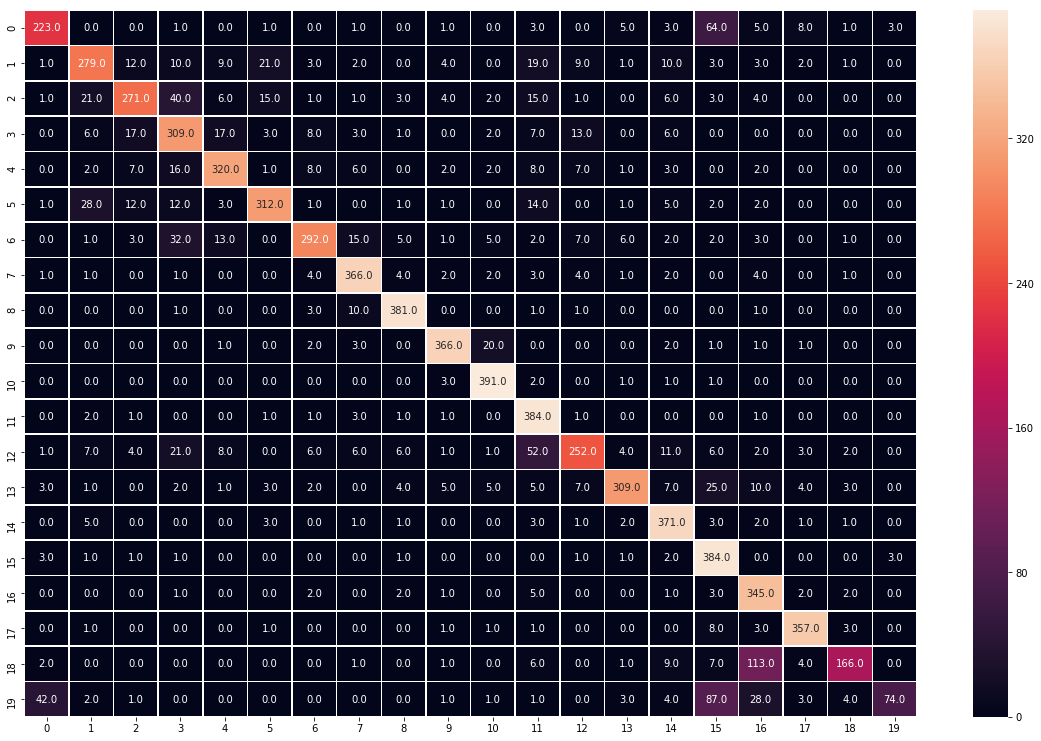

In [11]:
y_pred = nb_clf.predict(twenty_test.data)

print(classification_report(twenty_test.target, y_pred))
print('Stemmed Naive Bayes Accuracy:', np.mean(y_pred == twenty_test.target))
ax = plt.figure(figsize=(20, 13))
sns.heatmap(confusion_matrix(twenty_test.target, y_pred), linewidths=0.5, fmt='.1f', annot=True)

# Stemming SVM (Linear)

In [12]:
stem_count_vectorizer = StemmedCountVectorizer(stop_words='english')

svm_clf = Pipeline([('vector', stem_count_vectorizer), 
                   ('tfidf', TfidfTransformer()), 
                   ('clf', SGDClassifier(loss='hinge', penalty='l2', max_iter=5))])

text_clf = svm_clf.fit(twenty_train.data, twenty_train.target)

             precision    recall  f1-score   support

          0       0.81      0.75      0.78       319
          1       0.76      0.81      0.79       389
          2       0.76      0.72      0.74       394
          3       0.72      0.74      0.73       392
          4       0.81      0.85      0.83       385
          5       0.85      0.80      0.83       395
          6       0.82      0.88      0.85       390
          7       0.92      0.90      0.91       396
          8       0.95      0.96      0.96       398
          9       0.91      0.95      0.93       397
         10       0.95      0.97      0.96       399
         11       0.91      0.95      0.93       396
         12       0.83      0.75      0.79       393
         13       0.90      0.88      0.89       396
         14       0.90      0.92      0.91       394
         15       0.82      0.93      0.87       398
         16       0.75      0.92      0.83       364
         17       0.96      0.90      0.93   

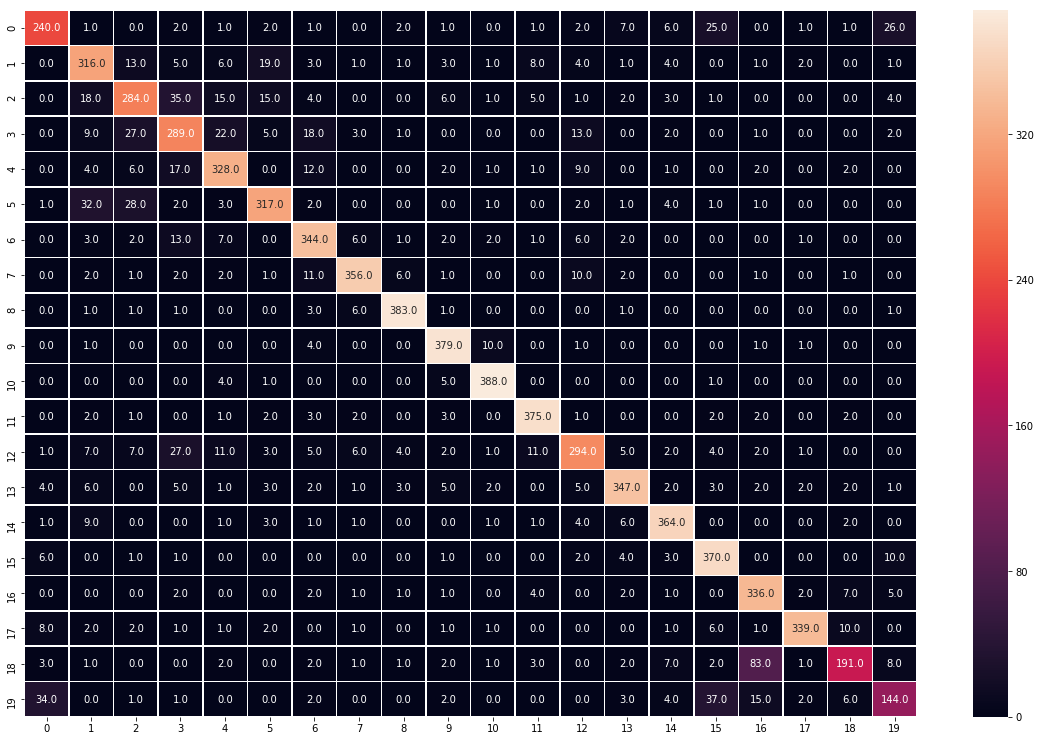

In [13]:
y_pred = text_clf.predict(twenty_test.data)

print(classification_report(twenty_test.target, y_pred))
print('Stemmed SVM Accuracy:', np.mean(y_pred == twenty_test.target))
ax = plt.figure(figsize=(20, 13))
sns.heatmap(confusion_matrix(twenty_test.target, y_pred), linewidths=0.5, fmt='.1f', annot=True)

# Deep Learning

In [14]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

Using TensorFlow backend.


In [15]:
def create_model():
    np.random.seed(0)
    model = Sequential()
    model.add(Dense(512, input_shape=(110995,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(20, activation='softmax'))

    model.compile('adam', loss='sparse_categorical_crossentropy')
    return model

In [16]:
np.random.seed(0)
stem_count_vectorizer = StemmedCountVectorizer(stop_words='english')
# early_stopping = EarlyStopping('val_loss', patience=1, verbose=2, mode='auto')
keras_classifier = KerasClassifier(build_fn=create_model, epochs=15, batch_size=128, 
                                   validation_split=0.1, callbacks=[])

deep_clf = Pipeline([('vector', stem_count_vectorizer), 
                   ('tfidf', TfidfTransformer()), 
                   ('clf', keras_classifier)])

deep_clf.fit(twenty_train.data, twenty_train.target)

Train on 10182 samples, validate on 1132 samples
Epoch 1/15
10182/10182 [==============================] - 10s 970us/step - loss: 2.0871 - val_loss: 0.6210
Epoch 2/15
10182/10182 [==============================] - 9s 857us/step - loss: 0.3298 - val_loss: 0.2749
Epoch 3/15
10182/10182 [==============================] - 9s 869us/step - loss: 0.0675 - val_loss: 0.2562
Epoch 4/15
10182/10182 [==============================] - 9s 867us/step - loss: 0.0289 - val_loss: 0.2666
Epoch 5/15
10182/10182 [==============================] - 9s 867us/step - loss: 0.0174 - val_loss: 0.2702
Epoch 6/15
10182/10182 [==============================] - 9s 864us/step - loss: 0.0153 - val_loss: 0.2692
Epoch 7/15
10182/10182 [==============================] - 9s 855us/step - loss: 0.0123 - val_loss: 0.2954
Epoch 8/15
10182/10182 [==============================] - 9s 870us/step - loss: 0.0118 - val_loss: 0.2937
Epoch 9/15
10182/10182 [==============================] - 9s 871us/step - loss: 0.0104 - val_loss: 0.2

Pipeline(memory=None,
     steps=[('vector', StemmedCountVectorizer(analyzer='word', binary=False, decode_error='strict',
            dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
            lowercase=True, max_df=1.0, max_features=None, min_df=1,
            ngram_range=(1, 1), preprocessor=None, stop_word...se, use_idf=True)), ('clf', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f37f2aae550>)])

             precision    recall  f1-score   support

          0       0.85      0.76      0.80       319
          1       0.73      0.77      0.75       389
          2       0.75      0.73      0.74       394
          3       0.74      0.72      0.73       392
          4       0.87      0.79      0.83       385
          5       0.89      0.75      0.81       395
          6       0.65      0.90      0.75       390
          7       0.96      0.83      0.89       396
          8       0.89      0.98      0.93       398
          9       0.94      0.95      0.94       397
         10       0.96      0.96      0.96       399
         11       0.92      0.93      0.93       396
         12       0.76      0.73      0.74       393
         13       0.90      0.80      0.85       396
         14       0.88      0.91      0.89       394
         15       0.84      0.93      0.88       398
         16       0.77      0.91      0.84       364
         17       0.95      0.91      0.93   

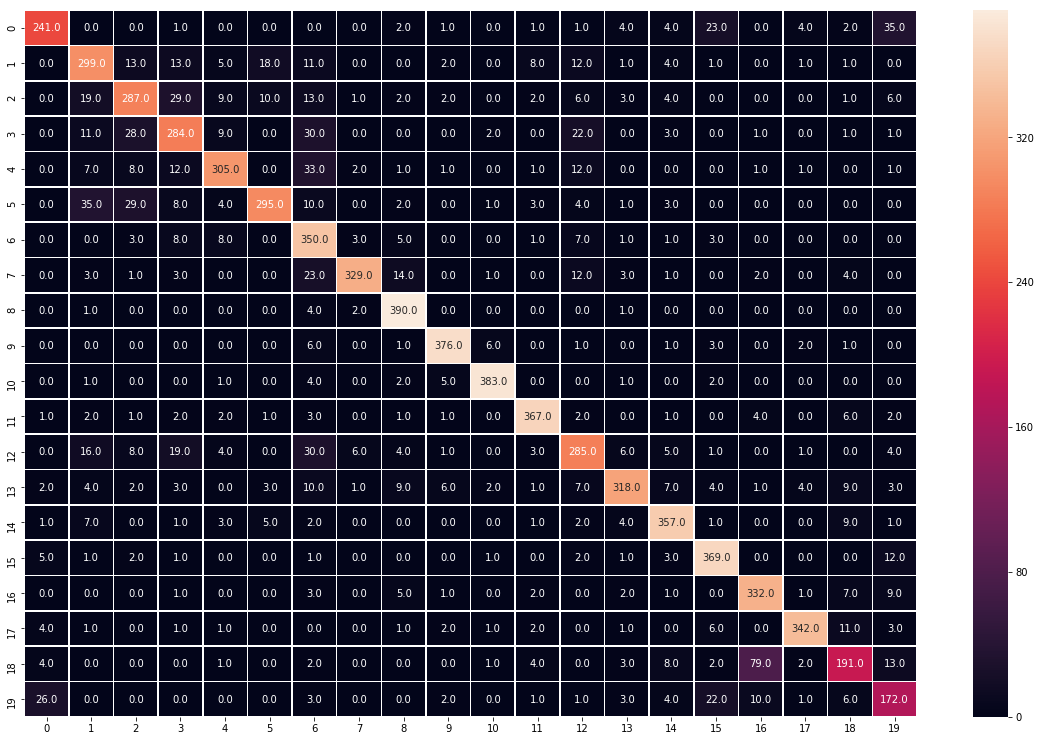

In [17]:
y_pred = deep_clf.predict(twenty_test.data)

print(classification_report(twenty_test.target, y_pred))
print('Stemmed Deep Learning Accuracy:', np.mean(y_pred == twenty_test.target))
ax = plt.figure(figsize=(20, 13))
sns.heatmap(confusion_matrix(twenty_test.target, y_pred), linewidths=0.5, fmt='.1f', annot=True)